# Prepare Environment
### Load Libraries and dependencies

In [1]:
import cudf
cudf.__version__

'24.02.02'

In [2]:
import cuml
cuml.__version__

'24.02.00'

In [3]:
import numpy as np
import cupy as cp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#import dask_ml.model_selection as dcv
from sklearn.model_selection import GridSearchCV
from dask.distributed import Client, wait
from dask_cuda import LocalCUDACluster

from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from cuml.neighbors import KNeighborsClassifier as cuNearestNeighbors
from cuml.model_selection import train_test_split
from cuml.metrics.accuracy import accuracy_score


import time
import os
import pickle
from contextlib import contextmanager

In [4]:
#Clear GPU memory when restarting kernel
import gc
import torch
torch.cuda.empty_cache()
gc.collect()

0

### Define Timer Function

In [5]:
# Helping time blocks of code
@contextmanager
def timed(txt):
    t0 = time.time()
    yield
    t1 = time.time()
    print("%32s time:  %8.5f" % (txt, t1 - t0))

In [6]:
#Set global seed var
seed = 40

In [7]:
### Silence WArnings
import warnings
warnings.filterwarnings("ignore")  # Reduce number of messages/warnings displayed

# Set GPU memory when restarting kernel

In [8]:
!nvidia-smi

Fri Apr 26 15:47:52 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        Off | 00000000:01:00.0 Off |                  N/A |
|  0%   34C    P3              41W / 420W |    478MiB / 24576MiB |     18%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [9]:
#Print GPU list
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3090 (UUID: GPU-f95b02b8-3c1a-8104-7eb1-25ec537b65e4)
GPU 1: NVIDIA GeForce RTX 2060 SUPER (UUID: GPU-9234d598-4065-602a-8139-1b0b2bc70750)


In [10]:
# Check if CUDA is available
cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")

CUDA available: True


### Spin up CUDA Cluster

In [11]:
#3090: GPU-f95b02b8-3c1a-8104-7eb1-25ec537b65e4
#2060S: GPU-9234d598-4065-602a-8139-1b0b2bc70750

cluster = LocalCUDACluster(protocol="ucx", #use ucx for inter-gpu training (RDMA, exclude cpu)
                           enable_tcp_over_ucx=None,
                           CUDA_VISIBLE_DEVICES= "0")
client = Client(cluster)

client

Connection method: Cluster object,Cluster type: dask_cuda.LocalCUDACluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 1,Total memory: 39.03 GiB
Status: running,Using processes: True
Comm: ucx://127.0.0.1:48867,Workers: 1
Dashboard: http://127.0.0.1:8787/status,Total threads: 1
Started: Just now,Total memory: 39.03 GiB
Comm: ucx://127.0.0.1:48911,Total threads: 1
Dashboard: http://127.0.0.1:33879/status,Memory: 39.03 GiB
Nanny: ucx://127.0.0.1:48961,


2024-04-26 16:11:17,337 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'ucx://127.0.0.1:48911', name: 0, status: running, memory: 0, processing: 0>
2024-04-26 16:11:17,339 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'ucx://127.0.0.1:48911'.
2024-04-26 16:11:19,650 - distributed.nanny - WARNING - Restarting worker
2024-04-26 16:34:36,901 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'ucx://127.0.0.1:56299', name: 0, status: running, memory: 0, processing: 0>
2024-04-26 16:34:36,903 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'ucx://127.0.0.1:56299'.
2024-04-26 16:34:39,319 - distributed.nanny - WARNING - Restarting worker


# Load Dataset

In [12]:
#Read smote data back to nb ad cuda df
X_train = pd.read_parquet(r"../../capstone_data/archive/SMOTE_train_test_split/X_train_smote.parquet")
y_train = pd.read_parquet(r"../../capstone_data/archive/SMOTE_train_test_split/y_train_smote.parquet")['label']
X_test = pd.read_parquet(r"../../capstone_data/archive/SMOTE_train_test_split/X_test_smote.parquet")
y_test = pd.read_parquet(r"../../capstone_data/archive/SMOTE_train_test_split/y_test_smote.parquet")['label']

print(type(X_train))
print(type(y_train))
print(type(X_test))
print(type(y_test))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


# Scale Dataset

In [13]:
#define numeric columns to be scaled
numeric_columns = ['duration', #extremely right skewed
                   'orig_bytes', #extremely right skewed
                   'resp_bytes', #extremely right skewed
                   'orig_pkts', #extremely right skewed
                   'resp_pkts', #extremely right skewed
                   'orig_ip_bytes', ##extremely right skewed
                   'resp_ip_bytes'] #extremely right skewed

In [14]:
# Scale data for KNN/SVC Algorithms
scaler = StandardScaler()


numeric_columns = ['duration', #extremely right skewed
                   'orig_bytes', #extremely right skewed
                   'resp_bytes', #extremely right skewed
                   'orig_pkts', #extremely right skewed
                   'resp_pkts', #extremely right skewed
                   'orig_ip_bytes', ##extremely right skewed
                   'resp_ip_bytes'] #extremely right skewed

#Log transformation for extremely right skewed distributions
constant = 1e-6
X_train[numeric_columns] = X_train[numeric_columns].apply(lambda x: np.log(x + constant))
X_test[numeric_columns] = X_test[numeric_columns].apply(lambda x: np.log(x + constant))

# Perform Gridsearch Hyperparameter Tuning
n_neighbors = 71 was found to be the optimal parameter.

In [15]:
#Convert data to gpu loadable type
X_train_gpu = cudf.DataFrame.from_pandas(X_train)
X_test_gpu = cudf.DataFrame.from_pandas(X_test)
y_train_gpu = cudf.Series.from_pandas(y_train)
y_test_gpu = cudf.Series.from_pandas(y_test)

In [16]:
# %%time
# from tqdm import tqdm

# neighbors_settings = range(15, 501,2)

# scores = []
# for n_neighbors in tqdm(neighbors_settings, desc="Testing different n_neighbors"):
#     # Build the model
#     knn = cuNearestNeighbors(n_neighbors=n_neighbors)
#     knn.fit(X_train_gpu, y_train_gpu)

#     # Make predictions
#     y_pred = knn.predict(X_test_gpu)

#     # Evaluate accuracy
#     accuracy = accuracy_score(y_test_gpu, y_pred)
#     scores.append(accuracy)
#     print(f"n_neighbors: {n_neighbors}, Accuracy: {accuracy}")

# # Determine the best n_neighbors value
# best_n_neighbors = neighbors_settings[np.argmax(scores)]
# print(f"Best number of neighbors: {best_n_neighbors}")

# Train and Test with Official Parameters

In [17]:
%%time
#Executes in 0.317secs
## Initialize model and fit

knn = cuNearestNeighbors(n_neighbors=71)
model = knn.fit(X_train_gpu, y_train_gpu)

CPU times: user 303 ms, sys: 51.2 ms, total: 355 ms
Wall time: 394 ms


In [18]:
%%time

#CPU times: user 23min 33s, sys: 3.73 s, total: 23min 37s
# Wall time: 23min 29s
#Make predictions
y_pred = model.predict(X_test_gpu)

2024-04-26 16:11:17,340 - distributed.worker - ERROR - Scheduler was unaware of this worker 'ucx://127.0.0.1:48911'. Shutting down.
2024-04-26 16:11:17,347 - distributed.core - INFO - Connection to ucx://127.0.0.1:48867 has been closed.


CPU times: user 23min 20s, sys: 3.79 s, total: 23min 24s
Wall time: 23min 17s


# Evaluate Model

In [19]:
#load model if already trained
# filename = '../trained_models/cuKNN_model_HPO_81accuracy.pkl'

# with open(filename, 'rb') as file:
#     model = pickle.load(file)

# y_pred = model.predict(X_test)

In [20]:
#Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred.to_pandas(), average='macro')
recall = recall_score(y_test, y_pred.to_pandas(), average='macro')
f1 = f1_score(y_test, y_pred.to_pandas(), average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

2024-04-26 16:11:19,348 - distributed.nanny - ERROR - Worker process died unexpectedly


Accuracy: 0.8142149448394775
Precision: 0.852946341218178
Recall: 0.8142021702410308
F1 Score: 0.8089700064736209


### Confusion Matrix

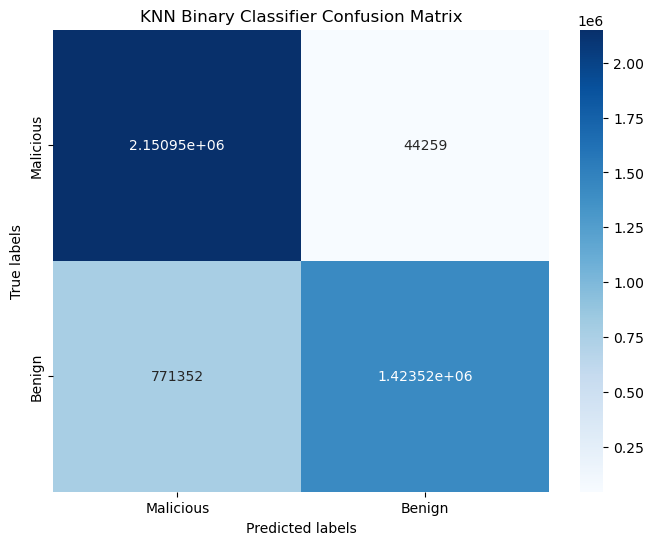

In [21]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred.to_pandas())

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Malicious', 'Benign'], yticklabels=['Malicious', 'Benign'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('KNN Binary Classifier Confusion Matrix')
plt.savefig('../../Graphs/Conf_Mat/KNN_HPO_CM_nneighbors71.png')
plt.show()

### ROC Curve

In [22]:
y_probs = model.predict_proba(X_test)
y_probs

2024-04-26 16:34:36,904 - distributed.worker - ERROR - Scheduler was unaware of this worker 'ucx://127.0.0.1:56299'. Shutting down.
2024-04-26 16:34:36,910 - distributed.core - INFO - Connection to ucx://127.0.0.1:48867 has been closed.
2024-04-26 16:34:38,911 - distributed.nanny - ERROR - Worker process died unexpectedly


,0,1
1705238,0.633803,0.366197
13645399,0.690141,0.309859
1483525,0.690141,0.309859
5277299,0.014085,0.985916
1209595,0.647888,0.352113
...,...,...
12659077,0.690141,0.309859
4656283,0.000000,1.000000
11929098,0.788733,0.211268
12833138,0.704226,0.295775


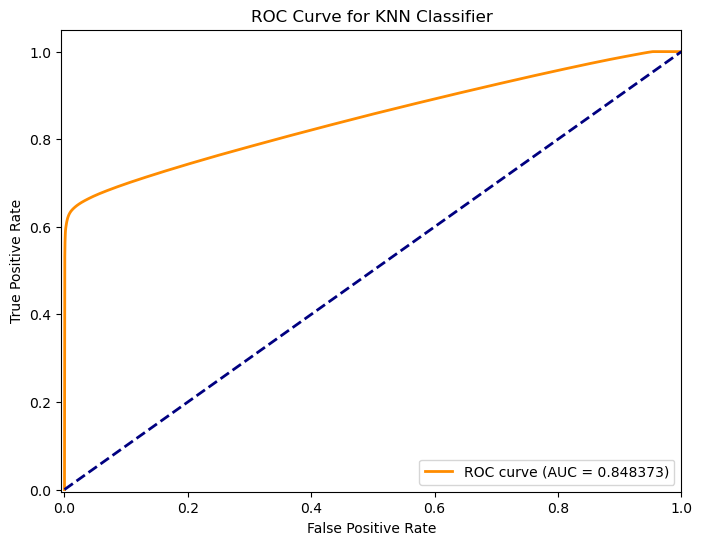

In [23]:
#Calculate prediction performance metrics
fpr, tpr, thresholds = roc_curve(y_test, y_probs[1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.6f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.005, 1.0])
plt.ylim([-0.005, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for KNN Classifier')
plt.legend(loc="lower right")
plt.savefig('../../Graphs/ROC_CUR/KNN_HPO_ROC_nneighbors71.png')
plt.show()

# Saving Trained Model

In [24]:
# Save the trained model using pickle
# model_filename = 'trained_models/cuKNN_model_HPO_81accuracy.pkl'
# with open(model_filename, 'wb') as file:
#     pickle.dump(model, file)